# MAP with Lambda

In this nb, we try to add the $\Lambda$ to the generative model and see how well it does recovering Claire's synthetic data.

A difference from Claire's code rn is: it's not clear what the mixture components for $\Lambda$ actually are in her implementation

Right now, when you run gradient descent, your L's get too small, and your A's get too big...why? Could it be something to do with the connectome prior?

I think the whole point of the lambdas is to do ARD...

TODO

* annoying behavior with D naning out
* why are you getting so much shrinkage with the Lambdas?
* why are you not getting perfect diagonals?
* maybe take a look at the diagonals?
* could the issue be with the connectome prior in the first place?
* what if you replace the ARD prior with beta random variables?

## Load libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy as np

from tqdm.auto import trange

from scipy.spatial import distance
from scipy.stats import pearsonr 
from scipy.optimize import linear_sum_assignment

import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.distributions.laplace import Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.distributions.dirichlet import Dirichlet
from torch.distributions.gamma import Gamma
from torch.distributions.exponential import Exponential
from torch.distributions.bernoulli import Bernoulli

def seed_everything(seed: int):
    """Sets the seed for generating random numbers in PyTorch, numpy and
    Python.

    Args:
        seed (int): The desired seed.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Create synthetic data

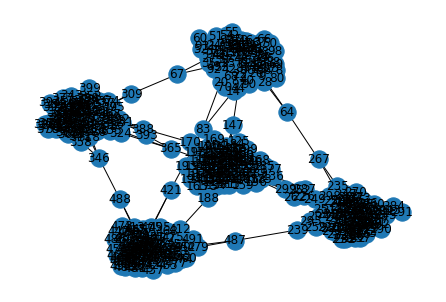

In [3]:
# make the synthetic graph
# Define the number of nodes and edges in the graph
num_nodes = 100
num_edges = 2
num_subgraphs = 5
T = 300

# Seed 
seed_everything(0)

# Create initial subgraph using Barabasi-Albert
edge_index = np.array(nx.barabasi_albert_graph(num_nodes, num_edges).edges())

# Add more subgraphs using the Barabasi-Albert
for s in range(1, num_subgraphs):
    new_edges = np.array(nx.barabasi_albert_graph(num_nodes, num_edges).edges()) + (s * num_nodes)
    edge_index = np.concatenate([edge_index, new_edges], axis=0)

# Convert the edge index to a NetworkX graph
g = nx.Graph()
g.add_edges_from(edge_index)

# Connect the subgraphs
for i in range(num_subgraphs):
    for j in range(i + 1, num_subgraphs):
        subgraph_i = set(range(i * num_nodes, (i + 1) * num_nodes))
        subgraph_j = set(range(j * num_nodes, (j + 1) * num_nodes))
        node_i = np.random.choice(list(subgraph_i))
        node_j = np.random.choice(list(subgraph_j))
        g.add_edge(node_i, node_j)

# Get the positions of the nodes using the spring layout algorithm
# Thanks chatgpt
pos = nx.spring_layout(g)

# Plot the graph using NetworkX and Matplotlib
nx.draw(g, pos=pos, with_labels=True)
plt.show()

Now it's time to make the synthetic time series

In [4]:
def nx_to_laplacian(g, alpha=0.5):
  """
  alpha: float, controls how much we augment the diagonal of the graph Laplacian
  """
  adj_matrix = nx.convert_matrix.to_numpy_array(g)
  deg = np.sum(adj_matrix, axis=1)
  lap = np.diag(alpha + deg) - adj_matrix
  return torch.from_numpy(lap).float()

In [5]:
def sample_model(K, N, T, g, sigma=0.01, random_seed=0, alpha=0.5):
  """
  This function samples data, but just creates an A (no D or L)

  K : number of factors
  N: number of neurons
  T: number of time steps
  g: the base graph (with N neurons)
  """
  seed_everything(random_seed)
  S = Laplace(0, 1/np.sqrt(2 * T)).sample(sample_shape=(T,K)) # T x k
  D = torch.sqrt(Dirichlet(torch.ones(K) / K).sample(sample_shape=(N,)).T)
  A = torch.abs(MultivariateNormal(torch.zeros(N),  precision_matrix=nx_to_laplacian(g, alpha=alpha)).sample(sample_shape=(K, ))) #k x N
  Y = Normal(S @ A, sigma).sample() # T x N

  return (S,A,Y)

In [6]:
def initialize_model(Y, K, N, T, g, sigma=0.01, random_seed=0, mask=True, alpha=0.5, slab_prob=0.8):
  """
  This function initializes our starting point for MAP estimation on L, D, A

  K : number of factors
  N: number of neurons
  T: number of time steps
  g: the base graph (with N neurons)
  """
  seed_everything(random_seed)
  S = Laplace(0, 1/np.sqrt(2 * T)).sample(sample_shape=(T,K)) # T x k
  D = torch.sqrt(Dirichlet(torch.ones(K) / K).sample(sample_shape=(N,)).T)
  A = torch.abs(MultivariateNormal(torch.zeros(N),  precision_matrix=nx_to_laplacian(g, alpha=alpha)).sample(sample_shape=(K, ))) #k x N

  # let's make the Lambdas
  B = Bernoulli(slab_prob).sample(sample_shape=(K,))
  L = B * Gamma(10,10).sample(sample_shape=(K,))
  E = (1 - B) * Exponential(1).sample(sample_shape=(K,))
  L = L + E
  # L = Beta(0.1, 0.1).sample(sample_shape=(K,))
  # L = L.sort().values


  if mask:
    Atilde = torch.diag(L) @ (D * A)
  else:
    Atilde = torch.diag(L) @ A

  # Anthony rescaling
  w = torch.linalg.norm(Y) / torch.linalg.norm(S @ Atilde)
  S = torch.sqrt(w) * S
  A = torch.sqrt(w) * A

  return (S,A,D,L)

In [7]:
S, A, Y = sample_model(num_subgraphs, num_subgraphs*num_nodes, T, g, random_seed=0)

## MAP estimation for the factor analysis

In [8]:
def stable_softmax(x):
    """
    Computes the numerically stable softmax of a tensor x on the first dimension.
    """
    max_val, _ = torch.max(x, dim=0, keepdim=True)
    x_exp = torch.exp(x - max_val)
    x_sum = torch.sum(x_exp, dim=0, keepdim=True)
    return x_exp / x_sum
def stable_dirichlet(logit_D):
    K, _ = logit_D.shape
    return ((1 - K) / K) * logit_D.sum()

In [9]:
def get_loss(Y, 
             S, 
             log_A, 
             logit_D, 
             log_L, 
             g, 
             sigma=0.01, 
             alpha=0.5, 
             beta=0,
             slab_prob=0.8,
             mask=True,
             ard=False):
  T, N = Y.shape
  K, _ = log_A.shape
  A = torch.exp(log_A)
  L = torch.exp(log_L)
  if mask:
    if logit_D.isnan().sum() > 0:
      print("D is nan")
    D = torch.sqrt(stable_softmax(logit_D.T).T)  # D_i^2 is Dirichlet

  loss = 0
  # priors
  loss += -Laplace(0, 1/np.sqrt(2 * T)).log_prob(S).sum()
  loss += -MultivariateNormal(torch.zeros(N), precision_matrix=nx_to_laplacian(g, alpha=alpha)).log_prob(A).sum()
  if mask:
    loss += -stable_dirichlet(logit_D)
  
  # ard (Lambda) loss
  if ard:
    # (Gamma mixture loss)
    gam = torch.log(torch.tensor(slab_prob)) + Gamma(10,10).log_prob(L)
    exp = torch.log(torch.tensor(1-slab_prob)) + Exponential(1).log_prob(L)
    cat = torch.vstack([gam, exp])
    loss += -torch.logsumexp(cat, 0).sum()
    # (Beta loss)
    # loss += - Beta(0.1,0.1).log_prob(L).sum()


  # likelihood
  if mask:
    Atilde = A * D
  else:
    Atilde = A
  if ard:
    Atilde = torch.diag(L) @ Atilde
  else:
    Atilde = Atilde
  loss += -Normal(S @ Atilde, sigma).log_prob(Y).sum()
  # l1 regularization
  loss += beta * torch.linalg.norm(A)
  return loss / T

In [10]:
def map_estimation(Y,
                   g,
                   K, 
                   N,
                   num_steps=10000,
                   alpha=0.5,
                   beta=0,
                   slab_prob=0.8,
                   mask=False,
                   ard=False,
                   random_seed=1,
                   tol_steps=1000):
  pbar = trange(num_steps)
  pbar.set_description("---")
  T, N = Y.shape
  # intialization
  S, A, D, L = initialize_model(Y, K, N, T, g, random_seed=random_seed, mask=mask, alpha=alpha, slab_prob=slab_prob)
  S = nn.parameter.Parameter(S)
  log_A = nn.parameter.Parameter(torch.log(A))
  logit_D = nn.parameter.Parameter(2 * torch.log(D)) #D_i^2 ~ Dirichlet
  log_L = nn.parameter.Parameter(torch.log(L))

  S_best = S
  log_A_best = log_A
  logit_D_best = logit_D
  log_L_best = log_L
  s = 0

  best_loss = float('inf')
  optimizer = optim.Adam([S,log_A, logit_D, log_L], lr=1e-1)
  train_losses = []
  for step in pbar:
    if step-s > max(s,tol_steps):
      break
    with torch.set_grad_enabled(True):
        optimizer.zero_grad()
        loss = get_loss(Y, S, log_A, logit_D, log_L, g, beta=beta, slab_prob=slab_prob, mask=mask, ard=ard)
        if loss < best_loss:
          s = step
          log_L_best = log_L.detach().clone()
          sort = log_L_best.sort()
          log_L_best = sort.values
          idxs = sort.indices

          S_best = S.detach().clone()
          S_best = S_best[:, idxs]

          log_A_best = log_A.detach().clone()
          log_A_best = log_A_best[idxs, :]

          logit_D_best = logit_D.detach().clone()
          logit_D_best = logit_D_best[idxs, :]

          best_loss = loss
        loss.backward()
        optimizer.step()
        if logit_D.isnan().sum() > 0:
          print("D is nan")
          break
          logit_D = torch.nan_to_num(logit_D)
        train_losses.append(loss.detach().numpy())

  print(s)
  return S_best, torch.exp(log_A_best), torch.sqrt(stable_softmax(logit_D_best)), torch.exp(log_L_best), train_losses

In [43]:
def make_stab_mat(A1, L1, D1, A2, L2, D2, ard=False, mask=False):
  K, _ = A1.shape
  if mask and ard:
    A_target = torch.diag(torch.sqrt(L1)) @ (D1 * A1)
  elif ~mask and ard:
    A_target = torch.diag(torch.sqrt(L1)) @ A1
  else:
    A_target = A1
  return make_recovery_mat(A_target, A2, L2, D2, ard=ard, mask=mask)

def make_recovery_mat(A_true, A_est, L_est, D_est, ard=False, mask=False):
  K_true, _ = A_true.shape
  K_used, _ = A_est.shape
  sim = np.zeros((K_true,K_used))
  for i in range(K_true):
    for j in range(K_used):
      if mask and ard:
        sim[i,j] = pearsonr(A_true[i], torch.sqrt(L_est[j]) * D_est[j] * A_est[j])[0]
      elif ~mask and ard:
        sim[i,j] = pearsonr(A_true[i], torch.sqrt(L_est[j]) * A_est[j])[0]
      else:
        sim[i,j] = pearsonr(A_true[i], A_est[j])[0]
  
  # just need to reorder the columns of sim according to the Hungarian algorithm
  if K_true==K_used:
    p = linear_sum_assignment(-sim)[1]
    sim = sim[:, p]

  return sim

In [12]:
ARD = True
MASK = False
K = 20
S_map, A_map, D_map, L_map, train_losses = map_estimation(Y, g, K, num_subgraphs * num_nodes, ard=ARD, mask=MASK)

  0%|          | 0/10000 [00:00<?, ?it/s]

4486


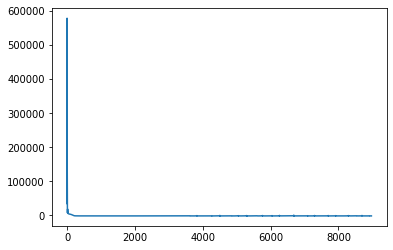

In [13]:
plt.plot(train_losses)

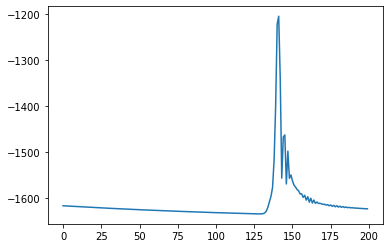

In [14]:
plt.plot(train_losses[-200:])

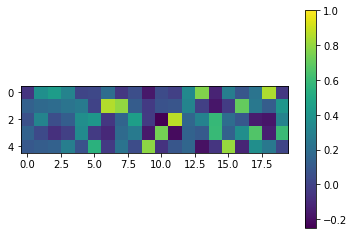

In [15]:
sim = make_recovery_mat(A, A_map, L_map, D_map, ard=ARD, mask=MASK)
plt.imshow(sim, vmin=-0.25, vmax=1)
plt.colorbar()

## Application to Claire's synthetic data

In [16]:
claire_synth_original = pd.read_csv("/content/drive/MyDrive/connectome_prior/claire_synthetic_data/claire_graph.csv")
claire_synth_scrambled1 = pd.read_csv("/content/drive/MyDrive/connectome_prior/claire_synthetic_data/claire_graph_scrambled1.csv")
claire_synth_scrambled2 = pd.read_csv("/content/drive/MyDrive/connectome_prior/claire_synthetic_data/claire_graph_scrambled2.csv")

# Clean up columns 
claire_synth_original.columns = range(len(claire_synth_original.columns))
claire_synth_scrambled1.columns = range(len(claire_synth_scrambled1.columns))
claire_synth_scrambled2.columns = range(len(claire_synth_scrambled2.columns))

In [17]:
def drop_stragglers(df):
  """
  Drop the unconnected nodes to ensure we have a fully connected network
  """
  G = nx.from_pandas_adjacency(df) 
  components = list(nx.connected_components(G))

  # Create a new graph containing only the nodes in the connected components
  H = nx.Graph()
  for component in components:
      H.add_edges_from(G.subgraph(component).edges())

  # Nodes in the original graph that are unconnected
  unconnected_nodes = set(G.nodes()) - set(H.nodes())

  # Remove the unconnected nodes from the original graph
  G.remove_nodes_from(unconnected_nodes)

  return G

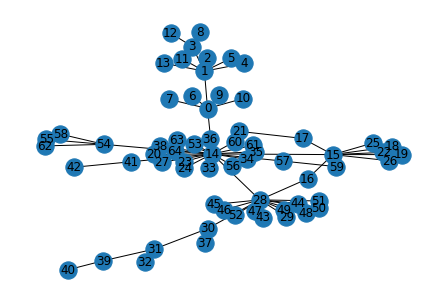

In [18]:
seed_everything(0)
G1 = drop_stragglers(claire_synth_original)
nx.draw(G1, with_labels=True)

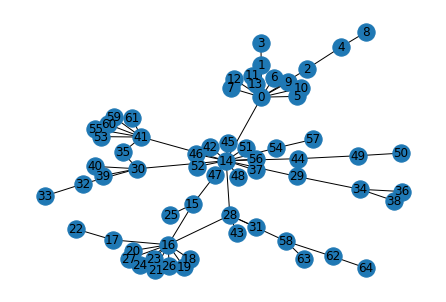

In [19]:
seed_everything(0)
G2 = drop_stragglers(claire_synth_scrambled1)
nx.draw(G2, with_labels=True)

In [20]:
N = 65
S1, A1, Y1 = sample_model(num_subgraphs, N, T, G1, random_seed=0)
S2, A2, Y2 = sample_model(num_subgraphs, N, T, G2, random_seed=0)

### Fitting on synthetic data with $k=5$

  0%|          | 0/10000 [00:00<?, ?it/s]

1123


Text(0.5, 1.0, 'Synthetic graph 1')

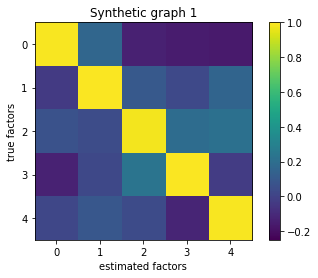

In [34]:
# k=5, for graph 1
MASK = False
ARD = False
K = num_subgraphs
SLAB_PROB = 0.5
S1_map, A1_map, D1_map, L1_map, train1_losses = map_estimation(Y1, G1, K, N, mask=MASK, ard=ARD, slab_prob=SLAB_PROB)
sim = make_recovery_mat(A1, A1_map, L1_map, D1_map, ard=ARD, mask=MASK)
plt.imshow(sim, vmin=-0.25, vmax=1)
plt.colorbar()
plt.xlabel("estimated factors")
plt.ylabel("true factors")
plt.title("Synthetic graph 1")

  0%|          | 0/10000 [00:00<?, ?it/s]

1975


Text(0.5, 1.0, 'Synthetic graph 2')

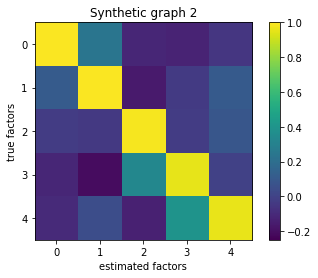

In [35]:
# k=5, for graph 2
MASK = False
ARD = False
K = num_subgraphs
SLAB_PROB = 0.5
S2_map, A2_map, D2_map, L2_map, train2_losses = map_estimation(Y2, G2, K, N, mask=MASK, ard=ARD, slab_prob=SLAB_PROB)
sim = make_recovery_mat(A2, A2_map, L2_map, D2_map, ard=ARD, mask=MASK)
plt.imshow(sim, vmin=-0.25, vmax=1)
plt.colorbar()
plt.xlabel("estimated factors")
plt.ylabel("true factors")
plt.title("Synthetic graph 2")

### Fitting on synthetic data with $k=10$.

In [36]:
MASK = False
ARD = True
K = 10
SLAB_PROB = 0.5
S1_map, A1_map, D1_map, L1_map, train1_losses = map_estimation(Y1, G1, K, N, mask=MASK, ard=ARD, slab_prob=SLAB_PROB)
S2_map, A2_map, D2_map, L2_map, train2_losses = map_estimation(Y2, G2, K, N, mask=MASK, ard=ARD, slab_prob=SLAB_PROB)

  0%|          | 0/10000 [00:00<?, ?it/s]

1667


  0%|          | 0/10000 [00:00<?, ?it/s]

1314


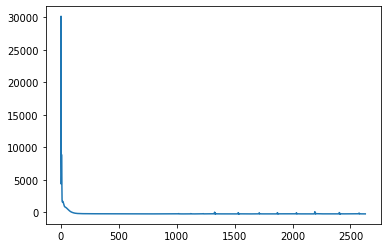

In [37]:
plt.plot(train2_losses)

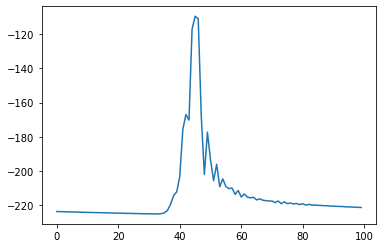

In [38]:
plt.plot(train2_losses[-100:])

Text(0.5, 1.0, 'Synthetic graph 1')

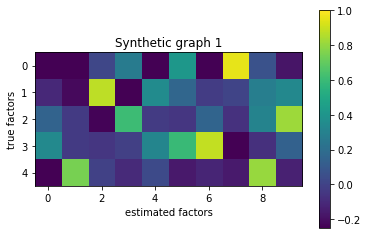

In [44]:
sim = make_recovery_mat(A1, A1_map, L1_map, D1_map, ard=ARD, mask=MASK)
plt.imshow(sim, vmin=-0.25, vmax=1)
plt.colorbar()
plt.xlabel("estimated factors")
plt.ylabel("true factors")
plt.title("Synthetic graph 1")

Text(0.5, 1.0, 'Synthetic graph 1')

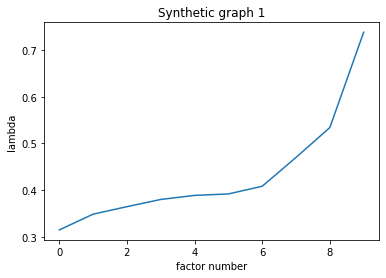

In [49]:
plt.plot(L1_map)
plt.xlabel("factor number")
plt.ylabel("lambda")
plt.title("Synthetic graph 1")

Text(0.5, 1.0, 'Synthetic graph 2')

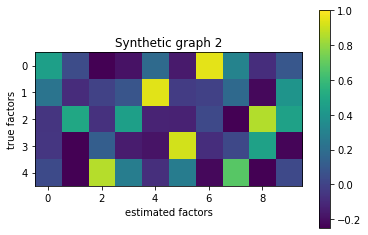

In [45]:
sim = make_recovery_mat(A2, A2_map, L2_map, D2_map, ard=ARD, mask=MASK)
plt.imshow(sim, vmin=-0.25, vmax=1)
plt.colorbar()
plt.xlabel("estimated factors")
plt.ylabel("true factors")
plt.title("Synthetic graph 2")

Text(0.5, 1.0, 'Synthetic graph 2')

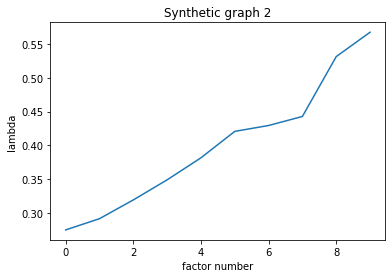

In [50]:
plt.plot(L2_map)
plt.xlabel("factor number")
plt.ylabel("lambda")
plt.title("Synthetic graph 2")